In [ ]:
pip install emukit


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 kB 7.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.4/959.4 kB 22.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emukit: filename=emukit-0.4.10-py3-none-any.whl size=257056 sha256=798c38faeb960fb672402004f8fc2176c9282bae141a168e828185c4fcc1bb0f
  Stored in directory: /root/.cache/pip/wheels/30/d1/af/64ddede19b5eb77bd70362edebf9d393bf77dc34d354c11292
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102548 sha256=81af1ec51ee57dffc

In [ ]:
import GPy
import emukit.multi_fidelity
import emukit.test_functions
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
%matplotlib inline

In [ ]:
pip install GPy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
# DNS_data=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Linewssdns_short.csv')
# RANS_data=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Linewssfullrans_short.csv')

DNS_data=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/pressDNS.csv')
RANS_data=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/pressRANS.csv')



Mounted at /content/drive


In [ ]:
# DNS_data=DNS_data*1000
# RANS_data=RANS_data*1000


In [ ]:
# Generate sample data

x_train_l =  np.array([[70,100],[70,80],[70,50],[70,30],[70,0],[60,100],[60,80],[60,50],[60,30],[60,0],[50,100],[50,80],[50,50],[50,30],[50,0],[40,100],[40,80],[40,50],[40,30],[40,0]])
x_train_h = np.array([[70,100],[70,0],[60,80],[50,50],[40,100],[40,0]])

DNS_full=DNS_data.dropna(axis=1)
DNS_full=DNS_full.values
DNS=DNS_full[:,[0,2,3,7,8,10]]
DNS=DNS[0:260,:]

DNS_test=DNS_full[:,[1,4,5,6,9]]
DNS_test=DNS_test[0:260,:]

RANS=RANS_data.dropna(axis=1)
RANS_full=RANS.values

RANS_test=RANS_full[:,[0,1,3,4,5,6,7,10,12,13,14,15,16,17,19]]
RANS=RANS_full[0:260,:]
RANS_test=RANS_test[0:260,:]
#D_70_100=np.array(DNS_data['70_100'])
#D_70_100=D_70_100.reshape(-1,1)
#np.stack(())
#print(column_values.shape)

DNS_full=np.transpose(DNS_full)
y_train_h=np.transpose(DNS)
y_train_l=np.transpose(RANS)


print(np.shape(y_train_h))
print(np.shape(y_train_l))

(6, 260)
(20, 260)


In [ ]:
# CI = np.ones(c[1])*1.96*hf_std_lin_mf_model[i,:].reshape(-1,1)
# CI=CI.T
# print(CI.shape)


In [ ]:
# x_train_l=np.c_[ x_train_l, np.zeros(len(x_train_l)) ]
# x_train_h=np.c_[ x_train_h, np.ones(len(x_train_h)) ]
# X_train=np.append(x_train_l,x_train_h,axis=0)
#
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays

# Y_train=np.append(y_train_h,y_train_l,axis=0)
X_train, Y_train = convert_xy_lists_to_arrays([x_train_l, x_train_h], [y_train_l, y_train_h])
print(X_train.shape)
print(Y_train.shape)

print(X_train)

(26, 3)
(26, 260)
[[ 70. 100.   0.]
 [ 70.  80.   0.]
 [ 70.  50.   0.]
 [ 70.  30.   0.]
 [ 70.   0.   0.]
 [ 60. 100.   0.]
 [ 60.  80.   0.]
 [ 60.  50.   0.]
 [ 60.  30.   0.]
 [ 60.   0.   0.]
 [ 50. 100.   0.]
 [ 50.  80.   0.]
 [ 50.  50.   0.]
 [ 50.  30.   0.]
 [ 50.   0.   0.]
 [ 40. 100.   0.]
 [ 40.  80.   0.]
 [ 40.  50.   0.]
 [ 40.  30.   0.]
 [ 40.   0.   0.]
 [ 70. 100.   1.]
 [ 70.   0.   1.]
 [ 60.  80.   1.]
 [ 50.  50.   1.]
 [ 40. 100.   1.]
 [ 40.   0.   1.]]


In [ ]:
## Create standard GP model using only high-fidelity data
x_train_DNS=x_train_h
y_train_DNS=y_train_h
kernelDNS = GPy.kern.ExpQuad(input_dim=2,lengthscale=[100,100],variance=0.0001, ARD=True)
kernelDNS.lengthscale.constrain_bounded(0,1000)
kernelDNS.variance.constrain_bounded(0,10)
high_gp_model = GPy.models.GPRegression(x_train_DNS, y_train_DNS, kernelDNS)
high_gp_model.Gaussian_noise.fix(0.0001)

## Fit the GP model

high_gp_model.optimize_restarts(100)


Optimization restart 1/100, f = 2163.485480039765
Optimization restart 2/100, f = 2163.485480039551
Optimization restart 3/100, f = 3344.0629632424843
Optimization restart 4/100, f = 2163.485480041903
Optimization restart 5/100, f = 2163.4854800395133
Optimization restart 6/100, f = 2163.4854800780986
Optimization restart 7/100, f = 2163.4854800527773
Optimization restart 8/100, f = 2163.485480153171
Optimization restart 9/100, f = 2163.485480040362
Optimization restart 10/100, f = 2163.4854800395406
Optimization restart 11/100, f = 2163.4854800644393
Optimization restart 12/100, f = 2163.485480060205
Optimization restart 13/100, f = 3312.2233966051754
Optimization restart 14/100, f = 2163.4854800397156
Optimization restart 15/100, f = 2163.485480071232
Optimization restart 16/100, f = 2163.485480061359
Optimization restart 17/100, f = 2163.4854800395497
Optimization restart 18/100, f = 2163.4854800408584
Optimization restart 19/100, f = 3312.2233972161816
Optimization restart 20/100, 

In [ ]:
print(high_gp_model.ExpQuad.lengthscale[0])
print(high_gp_model.ExpQuad.lengthscale[1])
print(high_gp_model.ExpQuad.variance)
print(high_gp_model.gradient)
# Get the gradients of optimization
gradients_dns = high_gp_model.gradient

# Get the names of the model's parameters
parameter_dns = high_gp_model.parameter_names()

# Print the gradients along with the parameter names
print("Gradients of Optimization:")
for i in range(len(parameter_dns)):
    print(f"Parameter: {parameter_dns[i]} - Gradient: {gradients_dns[i]}")


18.386214293434232
384.7481714691388
  index  |  GP_regression.ExpQuad.variance  |  constraints  |  priors
  [0]    |                      6.59156899  |   0.0,10.0    |        
[-1.46150840e-06  2.00576356e-07  1.14030466e-08  3.09705627e+03]
Gradients of Optimization:
Parameter: ExpQuad.variance - Gradient: -1.4615084019517277e-06
Parameter: ExpQuad.lengthscale - Gradient: 2.0057635552461091e-07
Parameter: Gaussian_noise.variance - Gradient: 1.1403046636505644e-08


In [ ]:
## Create standard GP model using only low-fidelity data

x_train_RANS= np.array([[70,100],[70,80],[70,30],[70,0],[60,100],[60,80],[60,50],[50,100],[50,50],[50,30],[50,0],[40,100],[40,80],[40,50],[40,0]])

y_train_RANS=np.transpose(RANS_test)
print(y_train_RANS.shape)

(15, 260)


In [ ]:
# Perform sensitivity analysis using Sobol indices
sensitivity = high_gp_model.input_sensitivity()

# Calculate the sum of sensitivity indices
sensitivity_sum = sum(sensitivity)

# Normalize the sensitivity indices
normalized_sensitivity = [index / sensitivity_sum for index in sensitivity]

# Calculate the total Sobol indices
total_sobol_indices = [index ** 2 for index in normalized_sensitivity]

# Normalize the total Sobol indices
total_sobol_sum = sum(total_sobol_indices)
normalized_total_sobol_indices = [index / total_sobol_sum for index in total_sobol_indices]

# Print the normalized total Sobol indices
print("Normalized Total Sobol Indices:")
for i, sobol_index in enumerate(normalized_total_sobol_indices):
    print(f"Variable {i+1}: {sobol_index}")


Normalized Total Sobol Indices:
Variable 1: 0.9999947849227332
Variable 2: 5.2150772668132666e-06


In [ ]:
# Perform sensitivity analysis using Sobol indices
sensitivity = high_gp_model.input_sensitivity()

# Normalize the sensitivity indices
sensitivity_sum = sum(sensitivity)
normalized_sensitivity = [index / sensitivity_sum for index in sensitivity]

# Print the normalized sensitivity indices
print("Normalized Sensitivity Indices:")
for i, sensitivity_index in enumerate(normalized_sensitivity):
    print(f"Variable {i+1}: {sensitivity_index}")

Normalized Sensitivity Indices:
Variable 1: 0.9977215429005738
Variable 2: 0.002278457099426166


In [ ]:
kernelRANS = GPy.kern.ExpQuad(input_dim=2,lengthscale=[10,10],variance=0.05, ARD=True)
kernelRANS.lengthscale.constrain_bounded(0,1000)
kernelRANS.variance.constrain_bounded(0,10)
low_gp_model = GPy.models.GPRegression(x_train_RANS, y_train_RANS, kernelRANS)
low_gp_model.Gaussian_noise.fix(0.1)

## Fit the GP model


low_gp_model.optimize_restarts(100)

Optimization restart 1/100, f = 1950.671683721177
Optimization restart 2/100, f = 1950.6716837239069
Optimization restart 3/100, f = 1950.6716837203608
Optimization restart 4/100, f = 1950.671683725561
Optimization restart 5/100, f = 1950.6716837214276
Optimization restart 6/100, f = 1950.6716863178872
Optimization restart 7/100, f = 1950.6716837197628
Optimization restart 8/100, f = 1950.6716837307963
Optimization restart 9/100, f = 1950.6716837201818
Optimization restart 10/100, f = 1950.6716837263157
Optimization restart 11/100, f = 1950.6716837209306
Optimization restart 12/100, f = 1950.6716840687616
Optimization restart 13/100, f = 1950.671684473757
Optimization restart 14/100, f = 1950.6716837519864
Optimization restart 15/100, f = 1950.6716837197418
Optimization restart 16/100, f = 2825.360472591964
Optimization restart 17/100, f = 1950.6716851760393
Optimization restart 18/100, f = 1950.6716837196816
Optimization restart 19/100, f = 1953.2468766843804
Optimization restart 20/1

In [ ]:
print(low_gp_model.ExpQuad.lengthscale[0])
print(low_gp_model.ExpQuad.lengthscale[1])
print(low_gp_model.ExpQuad.variance)

# Get the gradients of optimization
gradients_rans = low_gp_model.gradient

# Get the names of the model's parameters
parameter_rans = low_gp_model.parameter_names()

# Print the gradients along with the parameter names
print("Gradients of Optimization:")
for i in range(len(parameter_rans)):
    print(f"Parameter: {parameter_rans[i]} - Gradient: {gradients_rans[i]}")


18.49056969915354
239.16576798808435
  index  |  GP_regression.ExpQuad.variance  |  constraints  |  priors
  [0]    |                      6.96948274  |   0.0,10.0    |        
Gradients of Optimization:
Parameter: ExpQuad.variance - Gradient: -0.0002458536832189429
Parameter: ExpQuad.lengthscale - Gradient: 8.334852448738048e-05
Parameter: Gaussian_noise.variance - Gradient: 1.1622869497380268e-05


In [ ]:
# Perform sensitivity analysis using Sobol indices
sensitivity = low_gp_model.input_sensitivity()

# Normalize the sensitivity indices
sensitivity_sum = sum(sensitivity)
normalized_sensitivity = [index / sensitivity_sum for index in sensitivity]

# Print the normalized sensitivity indices
print("Normalized Sensitivity Indices:")
for i, sensitivity_index in enumerate(normalized_sensitivity):
    print(f"Variable {i+1}: {sensitivity_index}")

Normalized Sensitivity Indices:
Variable 1: 0.9940582499220897
Variable 2: 0.005941750077910382


In [ ]:
# Perform sensitivity analysis using Sobol indices
sensitivity = low_gp_model.input_sensitivity()

# Calculate the sum of sensitivity indices
sensitivity_sum = sum(sensitivity)

# Normalize the sensitivity indices
normalized_sensitivity = [index / sensitivity_sum for index in sensitivity]

# Calculate the total Sobol indices
total_sobol_indices = [index ** 2 for index in normalized_sensitivity]

# Normalize the total Sobol indices
total_sobol_sum = sum(total_sobol_indices)
normalized_total_sobol_indices = [index / total_sobol_sum for index in total_sobol_indices]

# Print the normalized total Sobol indices
print("Normalized Total Sobol Indices:")
for i, sobol_index in enumerate(normalized_total_sobol_indices):
    print(f"Variable {i+1}: {sobol_index}")


Normalized Total Sobol Indices:
Variable 1: 0.9999642735736178
Variable 2: 3.572642638216178e-05


In [ ]:
# Print the interaction terms
print("Interaction Terms:")
for i in range(len(sensitivity)):
    for j in range(i+1, len(sensitivity)):
        interaction = sensitivity[i] * sensitivity[j]
        print(f"Variable {i+1} x Variable {j+1}: {interaction}")


Interaction Terms:
Variable 1 x Variable 2: 2.483719067454097e-06


In [ ]:
kernels = [GPy.kern.ExpQuad(input_dim=2,lengthscale=[10,10],variance=0.005, ARD=True),GPy.kern.ExpQuad(input_dim=2,lengthscale=[10,10],variance=0.005, ARD=True)]
# for kernel in kernels:
#     kernel.lengthscale.constrain_bounded(0, 50)
#     kernel.variance.constrain_bounded(0, 10)
for i, kernel in enumerate(kernels):
    if i == 0:  # First fidelity
        kernel.lengthscale.constrain_bounded(0,1000)
        kernel.variance.constrain_bounded(0, 5)
    elif i == 1:  # Second fidelity
        kernel.lengthscale.constrain_bounded(0, 1000)
        kernel.variance.constrain_bounded(0, 10)
lin_mf_kernel = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(kernels)

gpy_lin_mf_model = GPyLinearMultiFidelityModel(X_train, Y_train, lin_mf_kernel, n_fidelities=2)

gpy_lin_mf_model.mixed_noise.Gaussian_noise.fix(0.0001)
gpy_lin_mf_model.mixed_noise.Gaussian_noise_1.fix(0.0001)

lin_mf_model =model=GPyMultiOutputWrapper(gpy_lin_mf_model, 2, n_optimization_restarts=50)

## Fit the model

lin_mf_model.optimize()

Optimization restart 1/50, f = 1266.5514921050012
Optimization restart 2/50, f = 1266.5514913982315
Optimization restart 3/50, f = 1266.5514921588033
Optimization restart 4/50, f = 1599.3399906532104
Optimization restart 5/50, f = 1266.5514916336015
Optimization restart 6/50, f = 1266.551496740717
Optimization restart 7/50, f = 1771.0285926676224
Optimization restart 8/50, f = 1266.5514914184873
Optimization restart 9/50, f = 1266.5514920846508
Optimization restart 10/50, f = 1266.5514914176365
Optimization restart 11/50, f = 1266.5514917215664
Optimization restart 12/50, f = 1599.340044517241
Optimization restart 13/50, f = 3640.012311258295
Optimization restart 14/50, f = 1266.5515022680238
Optimization restart 15/50, f = 1266.5514924195222
Optimization restart 16/50, f = 1266.5514929338178
Optimization restart 17/50, f = 1439.0478308121155
Optimization restart 18/50, f = 1266.5514914424725
Optimization restart 19/50, f = 1266.5514913773532
Optimization restart 20/50, f = 1599.340046

In [ ]:
 print(gpy_lin_mf_model)


Name : gp
Objective : 1266.5514913773532
Number of Parameters : 9
Number of Optimization Parameters : 7
Updates : True
Parameters:
  gp.                                    |                 value  |  constraints  |  priors
  multifidelity.ExpQuad.variance         |    1.9989219523727377  |    0.0,5.0    |        
  multifidelity.ExpQuad.lengthscale      |                  (2,)  |  0.0,1000.0   |        
  multifidelity.ExpQuad_1.variance       |  0.009657841425361533  |   0.0,10.0    |        
  multifidelity.ExpQuad_1.lengthscale    |                  (2,)  |  0.0,1000.0   |        
  multifidelity.scale                    |    1.0162367426791399  |               |        
  mixed_noise.Gaussian_noise.variance    |                0.0001  |   +ve fixed   |        
  mixed_noise.Gaussian_noise_1.variance  |                0.0001  |   +ve fixed   |        


In [ ]:
  print(gpy_lin_mf_model.multifidelity.ExpQuad.variance)
  print(gpy_lin_mf_model.multifidelity.ExpQuad_1.variance)
  print(gpy_lin_mf_model.multifidelity.ExpQuad.lengthscale)
  print(gpy_lin_mf_model.multifidelity.ExpQuad_1.lengthscale)

  index  |  gp.multifidelity.ExpQuad.variance  |  constraints  |  priors
  [0]    |                         1.99892195  |    0.0,5.0    |        
  index  |  gp.multifidelity.ExpQuad_1.variance  |  constraints  |  priors
  [0]    |                           0.00965784  |   0.0,10.0    |        
  index  |  gp.multifidelity.ExpQuad.lengthscale  |  constraints  |  priors
  [0]    |                            7.89813156  |  0.0,1000.0   |        
  [1]    |                           52.17442060  |  0.0,1000.0   |        
  index  |  gp.multifidelity.ExpQuad_1.lengthscale  |  constraints  |  priors
  [0]    |                             13.63974962  |  0.0,1000.0   |        
  [1]    |                             51.96106689  |  0.0,1000.0   |        


In [ ]:
# Get the gradients of optimization
gradients_mf = gpy_lin_mf_model.multifidelity.gradient

# Get the names of the model's parameters
parameter_mf = gpy_lin_mf_model.multifidelity.parameter_names()

# Print the gradients along with the parameter names
print("Gradients of Optimization:")
for i in range(len(parameter_mf)):
    print(f"Parameter: {parameter_mf[i]} - Gradient: {gradients_mf[i]}")

Gradients of Optimization:
Parameter: ExpQuad.variance - Gradient: -0.0006545808553903504
Parameter: ExpQuad.lengthscale - Gradient: 0.00024268670542152278
Parameter: ExpQuad_1.variance - Gradient: 1.5052167530409212e-05
Parameter: ExpQuad_1.lengthscale - Gradient: -0.010836062385815158
Parameter: scale - Gradient: -9.996131298958853e-05


In [ ]:

#x_plot=np.reshape(x,[10000,2])
x_plot=np.array([[70,50],[60,30],[60,0],[50,80],[40,30]])
X_plot_l=np.c_[ x_plot, np.zeros(len(x_plot)) ]
X_plot_h=np.c_[ x_plot, np.ones(len(x_plot)) ]

In [ ]:
hf_mean_lin_mf_model, hf_var_lin_mf_model = lin_mf_model.predict(X_plot_h)

hf_std_lin_mf_model = np.sqrt(hf_var_lin_mf_model)
hf_mean_high_gp_model, hf_var_high_gp_model  = high_gp_model.predict(X_plot_h)
lf_mean_low_gp_model, lf_var_low_gp_model  = low_gp_model.predict(X_plot_h)

In [ ]:
# print(np.amax(hf_mean_lin_mf_model))
print((np.sqrt(hf_var_lin_mf_model))*1.96)
print((np.sqrt(hf_var_high_gp_model))*1.96)
print((np.sqrt(lf_var_low_gp_model))*1.96)
# c=(hf_mean_lin_mf_model.shape)
# print(c)



[[0.10556517]
 [0.08851918]
 [0.10661364]
 [0.05931721]
 [0.07519834]]
[[0.0645258 ]
 [0.24116747]
 [0.38345716]
 [0.14769687]
 [0.05588979]]
[[0.49210228]
 [0.48639158]
 [0.51804879]
 [0.47733723]
 [0.49956231]]


In [ ]:
print(hf_var_lin_mf_model)
print(hf_var_high_gp_model)
print(lf_var_low_gp_model)

[[0.00292246]
 [0.00205779]
 [0.00298058]
 [0.00092805]
 [0.00148737]]
[[0.00109041]
 [0.0151646 ]
 [0.0383147 ]
 [0.00569354]
 [0.00081883]]
[[0.12325196]
 [0.12121467]
 [0.13272222]
 [0.11801932]
 [0.12593891]]


In [ ]:
print(hf_mean_lin_mf_model)
print(hf_mean_high_gp_model)
print(lf_mean_low_gp_model)

[[ 4.00670903  4.00634151  4.00596473 ... -1.91283843 -1.91314561
  -1.91352161]
 [ 2.00337936  2.00305963  2.00277604 ... -1.16823917 -1.16859841
  -1.16892655]
 [ 1.85153239  1.85124207  1.85094372 ... -1.36603236 -1.36667055
  -1.36741245]
 [ 1.35972326  1.35938766  1.35905719 ... -0.67622303 -0.67465682
  -0.67304897]
 [ 0.6734134   0.67311725  0.67277006 ... -0.32000014 -0.31858053
  -0.31719968]]
[[ 4.14222626  4.1418734   4.14157093 ... -2.07052485 -2.07465661
  -2.07873793]
 [ 1.93688301  1.93661549  1.93631673 ... -1.23775918 -1.23449519
  -1.23117302]
 [ 1.65162364  1.65137767  1.65108198 ... -1.26776963 -1.26257475
  -1.25734698]
 [ 1.36659113  1.36628611  1.36598468 ... -0.66587517 -0.66679477
  -0.66770323]
 [ 0.68406794  0.68375868  0.68345359 ... -0.32499399 -0.32346344
  -0.32193613]]
[[ 3.98305139  3.98285488  3.98265671 ... -1.65671676 -1.64446441
  -1.63225921]
 [ 2.00061177  2.00042738  2.00012421 ... -0.91108077 -0.89968923
  -0.88827244]
 [ 1.86735466  1.86716975 

In [ ]:
print(ytrain.shape)

NameError: ignored

(260, 1)
(260, 1)


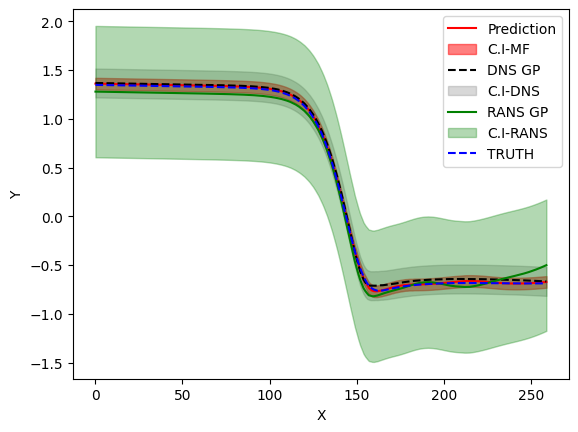

In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib import colors as mcolors
# colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
# fig,ax=plt.subplots()
# #DNS_test.shape[0]
# i=3

# x_pred = np.linspace(0,259,260).reshape(-1, 1)
# # Calculate upper and lower confidence bounds
# confidence = 1.96 # 95% confidence interval (approximate)
# lower_bound = hf_mean_lin_mf_model[i]- confidence * np.sqrt(hf_var_lin_mf_model[i])
# upper_bound = hf_mean_lin_mf_model[i]+ confidence * np.sqrt(hf_var_lin_mf_model[i])
# ax.plot(hf_mean_lin_mf_model[i],color='r',label='Prediction')
# ax.fill_between(x_pred.flatten(), lower_bound.flatten(), upper_bound.flatten(), color='red', alpha=0.5, label='C.I-MF')



# #for i in range(1):
# # ax.fill_between((hf_mean_lin_mf_model[0] - 1.96*hf_std_lin_mf_model[0]).flatten(),
# #(hf_mean_lin_mf_model[0] + 1.96*hf_std_lin_mf_model[0]).flatten(), color='r', alpha=0.3)
# # ax.plot(RANS_test[:,i],color='k',linestyle='dotted',label='RANS')
# ax.plot(hf_mean_high_gp_model[i],color='black',linestyle='--',label='DNS GP')
# lower_bound_dns = hf_mean_high_gp_model[i]- confidence * np.sqrt(hf_var_high_gp_model[i])
# upper_bound_dns = hf_mean_high_gp_model[i]+ confidence * np.sqrt(hf_var_high_gp_model[i])
# ax.fill_between(x_pred.flatten(), lower_bound_dns.flatten(), upper_bound_dns.flatten(), color='gray', alpha=0.3, label='C.I-DNS')
# ax.plot(lf_mean_low_gp_model[i],color='green',label='RANS GP')
# lower_bound_rans = lf_mean_low_gp_model[i]- confidence * np.sqrt(lf_var_low_gp_model[i])
# upper_bound_rans = lf_mean_low_gp_model[i]+ confidence * np.sqrt(lf_var_low_gp_model[i])
# ax.fill_between(x_pred.flatten(), lower_bound_rans.flatten(), upper_bound_rans.flatten(), color='green', alpha=0.3, label='C.I-RANS')
# ax.plot(DNS_test[:,i],color='b',linestyle='--',label='TRUTH')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.legend()


# x_data=x_pred
# y_truth=DNS_test[:,i].reshape(-1,1)

# print(y_truth.shape)
# print(x_data.shape)
# write_truth = np.stack((x_data,y_truth), axis = 1).reshape(-1,2)


# e= "streamwise WSS"
# hdrtxt='# xpoints','#ypoints'
# np.savetxt('/content/drive/MyDrive/ColabNotebooks/Truth_50_e80Press.dat', write_truth, delimiter='  ', header='Position\tMean', comments='' )


In [ ]:
print(np.sqrt(hf_var_high_gp_model[i]))
# print(x_pred)
print(lf_var_low_gp_model)
print(hf_var_high_gp_model)
print(hf_var_lin_mf_model)

In [ ]:
# CI = np.ones(c[1])*1.96*hf_std_lin_mf_model[i,:].reshape(-1,1)
# CI=CI.T
# print(CI.shape)
# i=4
# x_data=x_pred
# y_data=hf_mean_lin_mf_model[i].reshape(-1,1)

# y_hf=hf_mean_high_gp_model[i].reshape(-1,1)

# y_lf=lf_mean_low_gp_model[i].reshape(-1,1)

# print(y_data.shape)
# print(x_data.shape)
# write_mf = np.stack((x_data,y_data), axis = 1).reshape(-1,2)
# write_lf = np.stack((x_data,y_lf), axis = 1).reshape(-1,2)
# write_hf = np.stack((x_data,y_hf), axis = 1).reshape(-1,2)
# print(write_hf.shape)

# e= "streamwise WSS"
# hdrtxt='# xpoints','#ypoints'
# np.savetxt('/content/drive/MyDrive/ColabNotebooks/MF_40_e30Press.dat', write_mf, delimiter='  ', header='Position\tMean', comments='' )
# np.savetxt('/content/drive/MyDrive/ColabNotebooks/LF_40_e30Press.dat', write_lf, delimiter='  ', header='Position\tMean', comments='' )
# np.savetxt('/content/drive/MyDrive/ColabNotebooks/HF_40_e30Press.dat', write_hf, delimiter='  ', header='Position\tMean', comments='' )

(260, 1)
(260, 1)
(260, 2)


In [ ]:
# # Define the range of x values for prediction
# x_pred = np.linspace(0,50, 50).reshape(-1, 1)

# # Predict mean and variance at the given x values
# mean, var = model.predict(x_pred)

# # Calculate upper and lower confidence bounds
# confidence = 1.96  # 95% confidence interval (approximate)
# lower_bound = mean - confidence * np.sqrt(var)
# upper_bound = mean + confidence * np.sqrt(var)

# # Plot the data points, mean, and confidence interval
# plt.scatter(X_train, Y_train, color='red', label='Training data')
# plt.plot(x_pred, mean, color='blue', label='Mean')
# plt.fill_between(x_pred.flatten(), lower_bound.flatten(), upper_bound.flatten(), color='gray', alpha=0.3, label='Confidence interval')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('GPy Model Predictions with Confidence Interval')
# plt.legend()
# plt.show()

In [ ]:
fig,ax=plt.subplots()
for i in range(hf_mean_lin_mf_model.shape[0]):
   ax.plot(hf_mean_lin_mf_model[i])
ax.set_xlabel('X')
ax.set_ylabel('Y')


In [ ]:
# i=0
# y_true=DNS_test[:,i].reshape(-1,1)
# # y_rans=RANS_test[:,i].reshape(-1,1)


# write_truth = np.stack((x_data,y_true), axis = 1).reshape(-1,2)
# # write_rans = np.stack((x_data,y_rans), axis = 1).reshape(-1,2)


# np.savetxt('/content/drive/MyDrive/ColabNotebooks/Truth_70_e50ZL.dat', write_truth, delimiter='  ' )
# # np.savetxt('/content/drive/MyDrive/ColabNotebooks/RANS_70_e50.dat', write_rans, delimiter='   ' )


In [ ]:
print(lf_var_low_gp_model)
print(hf_var_high_gp_model)
print(hf_var_lin_mf_model)